In [ ]:
import torch
import torchvision
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary
import torchvision.transforms as transforms
from torchvision.datasets import MNIST
import torch.nn.functional as F
from torch.autograd import Variable
import tqdm




import numpy as np
import matplotlib.pyplot as plt

In [ ]:
!nvidia-smi

Fri Apr 22 13:57:32 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   36C    P8    29W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [ ]:
device=torch.device("cuda:0")

In [ ]:
device

device(type='cuda', index=0)

In [ ]:
img_transform=transforms.Compose([
      transforms.ToTensor(),
      transforms.Normalize(mean=(0.5,), std=(0.5,)),
      transforms.Lambda(lambda x:x.to(device))
])

test_img_transform=transforms.Compose([
      transforms.ToTensor()
])

train_dataset=MNIST("",transform=img_transform,train=True,download=True)
test_dataset=MNIST("",transform=test_img_transform,train=False,download=True)

batch_size=500
train_dl=torch.utils.data.DataLoader(train_dataset,batch_size=batch_size,shuffle=False)
test_dl=torch.utils.data.DataLoader(test_dataset,batch_size=batch_size,shuffle=True)


In [ ]:
class Generator(nn.Module):
  def __init__(self):
    super(Generator,self).__init__()
    self.gen=nn.Sequential(
        nn.ConvTranspose2d(100,28*8,4,2,1,bias=False),
        nn.BatchNorm2d(28*8),
        nn.ReLU(True),
        nn.ConvTranspose2d(28*8,28*4,4,2,1,bias=False),
        nn.BatchNorm2d(28*4),
        nn.ReLU(True),
        nn.ConvTranspose2d(28*4,28*2,4,2,1,bias=False),
        nn.BatchNorm2d(28*2),
        nn.ReLU(True),
        nn.ConvTranspose2d(28*2,28,2,2,1,bias=False),
        nn.BatchNorm2d(28),
        nn.ReLU(True),
        nn.ConvTranspose2d(28,1,4,2,1,bias=False),
        nn.Tanh(),
        
    )
  def forward(self,x):
    return(self.gen(x))

In [ ]:
class Discriminator(nn.Module):
  def __init__(self):
    super(Discriminator,self).__init__()
    self.r=torchvision.models.resnet18(pretrained=False, progress=True)
    self.r.conv1 = nn.Conv2d(1,64,kernel_size=(7,7))
    self.r.fc = nn.Linear(in_features=512, out_features=2)

  def forward(self,x):
    return self.r(x)

In [ ]:
def noise(size):
  return torch.rand(size,100,1,1).to(device)

In [ ]:
gen=Generator().to(device)
disc=Discriminator().to(device)

gen_loss=nn.CrossEntropyLoss()
disc_loss=nn.CrossEntropyLoss()

gen_optimizer=optim.Adam(gen.parameters(),lr=0.001)
disc_optimizer=optim.Adam(disc.parameters(),lr=0.001)

In [ ]:
generator_loss_data=[]
discriminator_loss_data=[]

def plot_random_images(gen):
  plt.figure(figsize=(10,5))
  images_cur=gen(noise(10))
  n=1
  for i in images_cur:
    plt.subplot(2,5,n)
    plt.imshow(i.transpose(0,2).detach().cpu().numpy()[:,:,0],cmap="gray")
    n+=1
  plt.show()

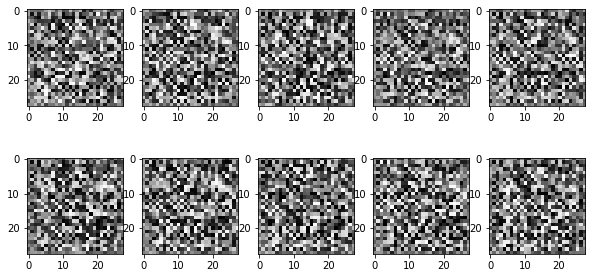

In [ ]:
plot_random_images(gen)

In [ ]:
def discriminator_train_step(real_data,fake_data):
  disc_optimizer.zero_grad()
  pred=disc(real_data)
  error_real=disc_loss(pred,torch.ones(batch_size).type(torch.LongTensor).to(device))
  error_real.backward()

  pred_fake=disc(fake_data)
  error_fake=disc_loss(pred_fake,torch.zeros(batch_size).type(torch.LongTensor).to(device))
  error_fake.backward()

  disc_optimizer.step()

  return error_fake.item()+error_real.item()

In [ ]:
def generator_train_step(real_data,fake_data):
  gen_optimizer.zero_grad()
  pred=disc(fake_data)
  error=disc_loss(pred,torch.ones(batch_size).type(torch.LongTensor).to(device))
  error.backward()
  gen_optimizer.step()
  return error.item()

In [ ]:
torch.autograd.set_detect_anomaly(True)

  0%|          | 0/10 [00:00<?, ?it/s]

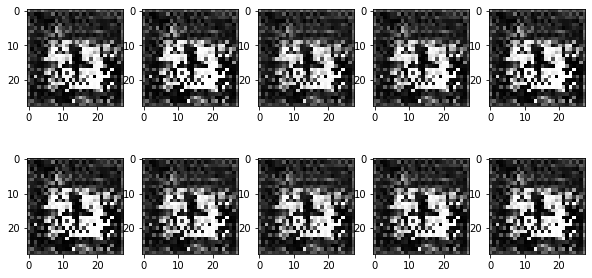

 10%|█         | 1/10 [02:38<23:46, 158.56s/it]

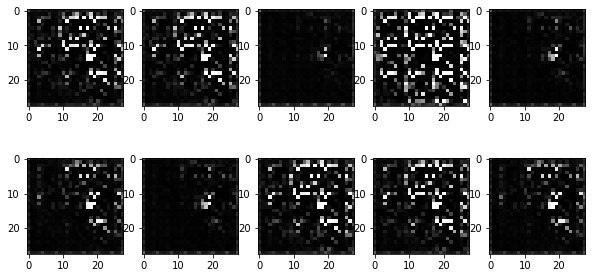

 20%|██        | 2/10 [05:17<21:08, 158.56s/it]

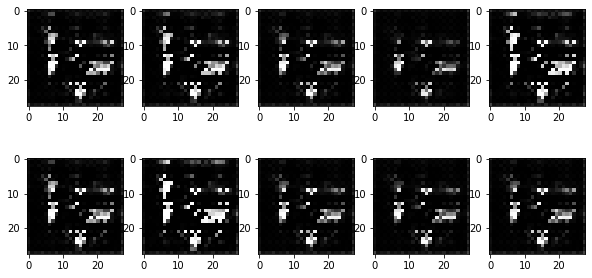

 30%|███       | 3/10 [07:55<18:29, 158.49s/it]

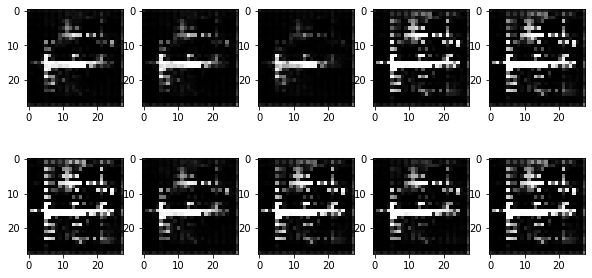

 40%|████      | 4/10 [10:34<15:50, 158.49s/it]

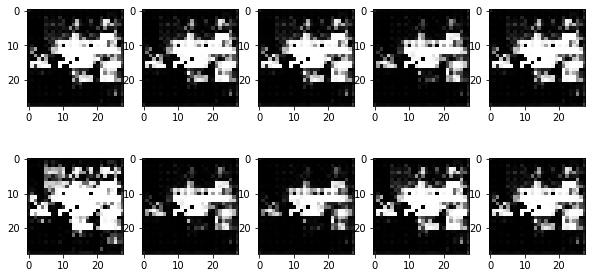

 50%|█████     | 5/10 [13:12<13:12, 158.45s/it]

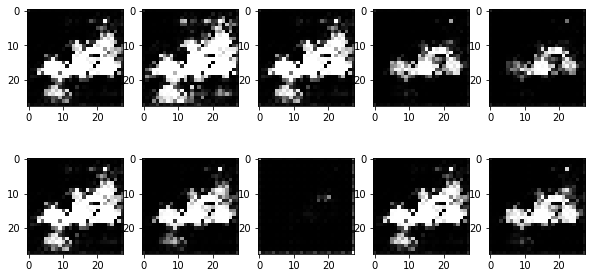

 60%|██████    | 6/10 [15:50<10:33, 158.40s/it]

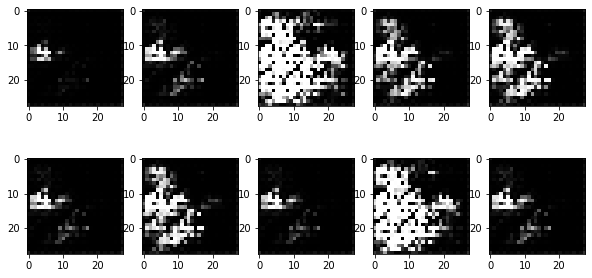

 70%|███████   | 7/10 [18:28<07:54, 158.29s/it]

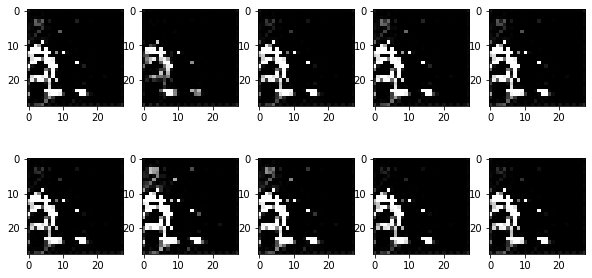

 80%|████████  | 8/10 [21:06<05:16, 158.13s/it]

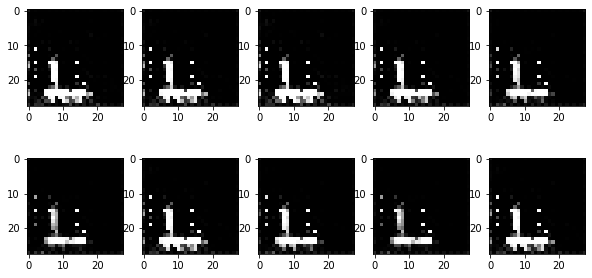

 90%|█████████ | 9/10 [23:44<02:37, 157.96s/it]

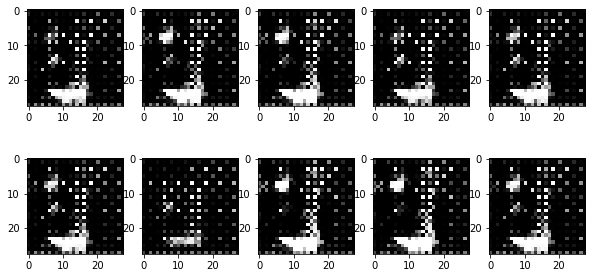

100%|██████████| 10/10 [26:21<00:00, 158.16s/it]


In [ ]:
n_epochs=10

for epoch in tqdm.tqdm(range(n_epochs)):
  for (images,labels) in train_dl:

    noise_data=noise(batch_size)
    fake_data=gen(noise_data)

    d_loss=discriminator_train_step(images,fake_data)


    fake_data=gen(noise_data)
    g_loss=generator_train_step(images,fake_data)



    discriminator_loss_data.append(d_loss)
    generator_loss_data.append(g_loss)

  plot_random_images(gen)